<h1 style="background: #ea97ad;text-align:center">Autocorrect Tool via Minimum Distance Edit</h1>

In this notebook, I aim to build a basic *auto-correction tool* using Dynamic Programming. The rest of the notbook is organized as follows:

1. Brief Overview
2. Data Preprocessing
3. Word Count
4. Computing Word Probability
5. Performing String Manipulations:
    1. Replace
    2. Insert
    3. Delete
    4. Switch
6. Combining the Edits
    1. Edit One Letter
    2. Edit Two Letters
7. Spelling Suggestions
8. Minimum Edit Distance
    1. Dynamic Programming

<h1 style="background: #ea97ad;text-align:center">Overview</h1>

We use the autocorrect functionality everyday on our laptops, cell phones, computers etc. In this notebook, I aim to create a basic auto-correct tool and explore what goes on behind the scenes. One example of autocorrect is, if you type the word **rnunnuing**, chances are very high that you meant to write **running** as shown in Figure 1.

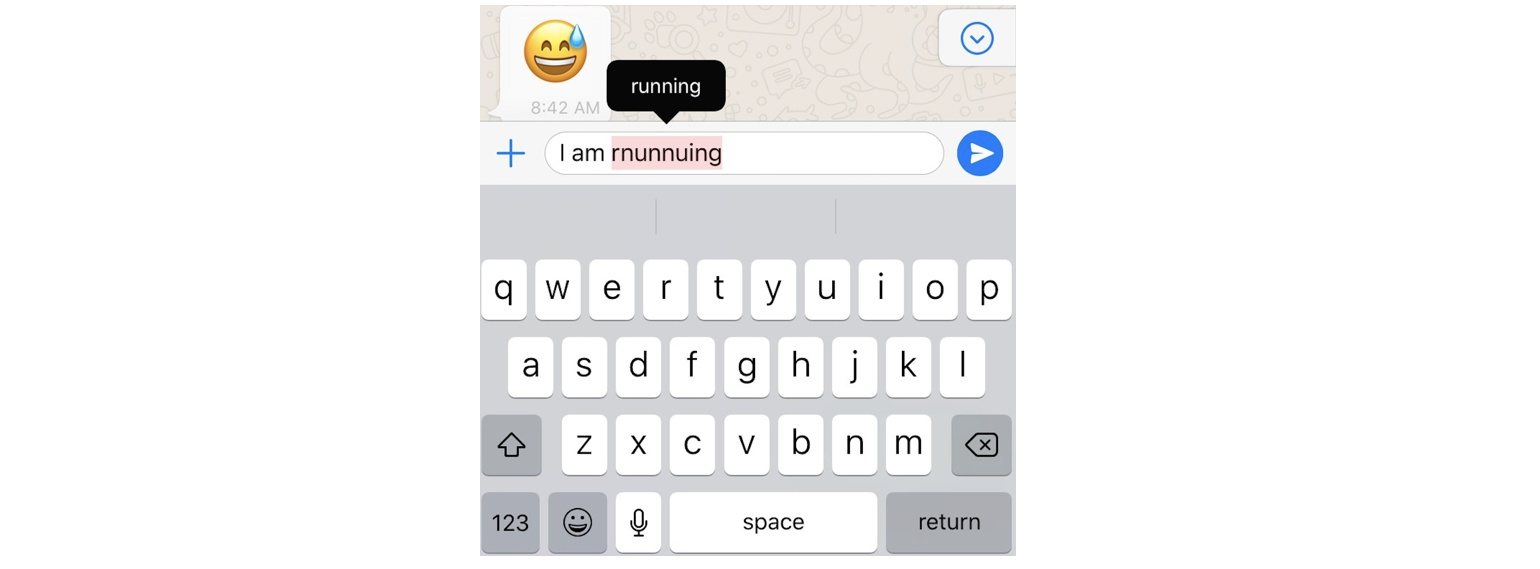

<h1 style="background: #ea97ad;text-align:center">Data Preprocessing</h1>

In this task, we will read a file, **shakespeare.txt** and perform the following preprocessing steps:
1. Read the corpus (txt) file.
2. Change everything to lowercase
3. Return a list of words

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/vocabulary/shakespeare.txt


In [2]:
import re
from collections import Counter
import numpy as np
import pandas as pd

In [3]:
from nltk.tokenize import word_tokenize

def process_data(file_name):
    """
    Input: 
        A file_name which is found in our current Kaggle directory. We just have to read it in. 
    Output: 
        words: a list containing all the words in the corpus in lower case. 
    """
    words = [] 

    with open(file_name, 'r') as file:
        file_read = file.read()
        pre_process_file = re.findall(r"\w+", file_read)
        word_list = pre_process_file
        for word in word_list:
            words.append(word.lower())
    
    return words

In [4]:
word_list = process_data('/kaggle/input/vocabulary/shakespeare.txt')
vocab = set(word_list)  # this will be our new vocabulary

<h1 style="background: #ea97ad;text-align:center">Word Count</h1>

In this part, we will implement a `get_count` function that returns a dictionary where:
1. Dictionary's keys are words.
2. The value for each word is the number of times that word appears in the corpus.

Example, given the following sentence: "**I am running because I am happy**", our dictionary should return the following:

| **Key** | **Value** |
|---------|-----------|
| I       | 2         |
| am      | 2         |
| happy   | 1         |
| because | 1         |
| running | 1         |

In [5]:
def get_count(word_list):
    '''
    Input:
        word_l: a set of words representing the corpus. 
    Output:
        word_count_dict: The wordcount dictionary where key is the word and value is its frequency.
    '''
    
    word_count_dict = {}  # create word_count dictionary
    word_count_dict = Counter(word_list)
            
    return word_count_dict

In [6]:
word_count_dict = get_count(word_list)
print(f"There are {len(word_count_dict)} key values pairs")
print(f"The count for the word 'thee' is {word_count_dict.get('thee',0)}")

There are 6116 key values pairs
The count for the word 'thee' is 240


<h1 style="background: #ea97ad;text-align:center">Computing the Word Probability</h1>

We can leverage the `word_count_dict` to calculate the probability that each word will appear if randomly selected from the corpus of words. The probability can be calculate using the equation (1).


$$P(w_i) = \frac{C(w_i)}{M} \tag{1}$$
where 

$C(w_i)$ is the total number of times $w_i$ appears in the corpus.

$M$ is the total number of words in the corpus.

For example, in the sentence: "**I am running because I am happy**", the probability of the word '**running**' is:

$$P('running') = \frac{C(w_i)}{M} = \frac {1}{7} \tag{2}.$$


In [7]:
def get_probs(word_count_dict):
    '''
    Input:
        word_count_dict: The wordcount dictionary where key is the word and value is its frequency.
    Output:
        probs: A dictionary where keys are the words and the values are the probability that a word will occur. 
    '''
    probs = {}  # initalize the probability dictionary
    total_words = sum(word_count_dict.values()) # variable M

    for word, word_count in word_count_dict.items():
        word_prob = word_count/total_words
        probs[word] = word_prob
    
    return probs

In [8]:
print(word_count_dict['thee'])
probs = get_probs(word_count_dict)
print(f"Length of probs is {len(probs)}")
print(f"P('thee') is {probs['thee']:.4f}")

240
Length of probs is 6116
P('thee') is 0.0045


<h1 style="background: #ea97ad;text-align:center">Performing String Manipulations</h1>

Now, that we have computed $P(w_i)$ for all the words in the corpus, we will write a few functions to manipulate strings so that we can edit the erroneous strings and return the right spellings of the words. In this section, we will implement four functions: 

* `delete_letter`: given a word, it returns all the possible strings that have **one character removed**. 
* `switch_letter`: given a word, it returns all the possible strings that have **two adjacent letters switched**.
* `replace_letter`: given a word, it returns all the possible strings that have **one character replaced by another different letter**.
* `insert_letter`: given a word, it returns all the possible strings that have an **additional character inserted**. 

<h2 style="background: #ea97ad;text-align:center">String Manipulation: Delete Letter</h2>

Here, we will implement a function, `delete_letter()` which, given a word, returns a list of strings with one character deleted. For example:
Given the word **nice**, it would return the set: {'ice', 'nce', 'nic', 'nie'}. 

In [9]:
def delete_letter(word, verbose=False):
    '''
    Input:
        word: the string/word for which we will generate all possible words 
                in the vocabulary which have 1 missing character
    Output:
        delete_list: a list of all possible strings obtained by deleting 1 character from word
    '''
    
    delete_list = []
    split_list = []
    
    # split_list will generate: [('', 'cans'), ('c', 'ans'), ('ca', 'ns'), ('can', 's')]
    split_list = [(word[:i], word[i:]) for i in range(len(word))]
    
    # delete_list will generate: ['ans', 'cns', 'cas', 'can']
    # deletes one char from the word
    delete_list = [L+R[1:] for L, R in split_list]
    

    if verbose: print(f"input word {word}, \nsplit_list = {split_list}, \ndelete_list = {delete_list}")

    return delete_list

In [10]:
delete_word_list = delete_letter(word="cans",verbose=True)

input word cans, 
split_list = [('', 'cans'), ('c', 'ans'), ('ca', 'ns'), ('can', 's')], 
delete_list = ['ans', 'cns', 'cas', 'can']


<h2 style="background: #ea97ad;text-align:center">String Manipulation: Switch Letter</h2>

Here, we will implement a function that switches two letters in a word. It takes in a word and returns a list of all the possible switches of two letters **that are adjacent to each other.**

For example, given the word 'eta', it returns {'eat', 'tea'}, but does not return 'ate'.

In [11]:
def switch_letter(word, verbose=False):
    '''
    Input:
        word: input string
     Output:
        switches: a list of all possible strings with one adjacent charater switched
    ''' 
    
    switch_list = []
    split_list = []

    split_list = [(word[:i], word[i:]) for i in range(len(word))]
    #.  a.    b. 
    # ('e', 'ta') => L + R[1] + R[0] + R[2:] => eat
    switch_list = [L + R[1] + R[0] + R[2:] for L, R in split_list if len(R)>=2]
    
    if verbose: print(f"Input word = {word} \nsplit_list = {split_list} \nswitch_list = {switch_list}") 

    return switch_list

In [12]:
switch_word_list = switch_letter(word="eta",verbose=True)

Input word = eta 
split_list = [('', 'eta'), ('e', 'ta'), ('et', 'a')] 
switch_list = ['tea', 'eat']


<h2 style="background: #ea97ad;text-align:center">String Manipulation: Replace Letter</h2>

Here, we will implement a function that takes in a word and returns a list of strings with one replaced letter from the original word.


In [13]:
def replace_letter(word, verbose=False):
    '''
    Input:
        word: the input string/word 
    Output:
        replaces: a list of all possible strings where we replaced one letter from the original word. 
    ''' 
    
    letters = 'abcdefghijklmnopqrstuvwxyz'
    replace_list = []
    split_list = []
    
    split_list = [(word[0:i], word[i:]) for i in range(len(word))]
    
    replace_list = [L + letter + (R[1:] if len(R)>1 else '') for L, R in split_list if R for letter in letters]
    
    replace_set = set(replace_list)
    
    # turn the set back into a list and sort it, for easier viewing
    replace_list = sorted(list(replace_set))

    
    if verbose: print(f"Input word = {word} \nsplit_list = {split_list} \nreplace_list {replace_list}")   
    
    return replace_list

In [14]:
replace_list = replace_letter(word='can', verbose=True)

Input word = can 
split_list = [('', 'can'), ('c', 'an'), ('ca', 'n')] 
replace_list ['aan', 'ban', 'caa', 'cab', 'cac', 'cad', 'cae', 'caf', 'cag', 'cah', 'cai', 'caj', 'cak', 'cal', 'cam', 'can', 'cao', 'cap', 'caq', 'car', 'cas', 'cat', 'cau', 'cav', 'caw', 'cax', 'cay', 'caz', 'cbn', 'ccn', 'cdn', 'cen', 'cfn', 'cgn', 'chn', 'cin', 'cjn', 'ckn', 'cln', 'cmn', 'cnn', 'con', 'cpn', 'cqn', 'crn', 'csn', 'ctn', 'cun', 'cvn', 'cwn', 'cxn', 'cyn', 'czn', 'dan', 'ean', 'fan', 'gan', 'han', 'ian', 'jan', 'kan', 'lan', 'man', 'nan', 'oan', 'pan', 'qan', 'ran', 'san', 'tan', 'uan', 'van', 'wan', 'xan', 'yan', 'zan']


<h2 style="background: #ea97ad;text-align:center">String Manipulation: Insert Letter</h2>

Here, we will implement a function that takes in a word and returns a list with a letter inserted at every offset. 

In [15]:
def insert_letter(word, verbose=False):
    '''
    Input:
        word: the input string/word 
    Output:
        inserts: a set of all possible strings with one new letter inserted at every offset
    ''' 
    letters = 'abcdefghijklmnopqrstuvwxyz'
    insert_list = []
    split_list = []
    
    # adding extra 1 because for insertion, we want that empty tuple!
    split_list = [(word[0:i], word[i:]) for i in range(len(word)+1)]
    insert_list = [L + letter + R for L, R in split_list for letter in letters]

    if verbose: print(f"Input word {word} \nsplit_list = {split_list} \ninsert_list = {insert_list}")
    
    return insert_list

In [16]:
insert_list = insert_letter('at', True)
print(f"Number of strings output by insert_letter('at') is {len(insert_list)}")

Input word at 
split_list = [('', 'at'), ('a', 't'), ('at', '')] 
insert_list = ['aat', 'bat', 'cat', 'dat', 'eat', 'fat', 'gat', 'hat', 'iat', 'jat', 'kat', 'lat', 'mat', 'nat', 'oat', 'pat', 'qat', 'rat', 'sat', 'tat', 'uat', 'vat', 'wat', 'xat', 'yat', 'zat', 'aat', 'abt', 'act', 'adt', 'aet', 'aft', 'agt', 'aht', 'ait', 'ajt', 'akt', 'alt', 'amt', 'ant', 'aot', 'apt', 'aqt', 'art', 'ast', 'att', 'aut', 'avt', 'awt', 'axt', 'ayt', 'azt', 'ata', 'atb', 'atc', 'atd', 'ate', 'atf', 'atg', 'ath', 'ati', 'atj', 'atk', 'atl', 'atm', 'atn', 'ato', 'atp', 'atq', 'atr', 'ats', 'att', 'atu', 'atv', 'atw', 'atx', 'aty', 'atz']
Number of strings output by insert_letter('at') is 78


<h1 style="background: #ea97ad;text-align:center">Combining the Edits</h1>

Now that we have implemented a number of string manipulations functions *(insert, delete, switch and replace)*, we will now create two functions that, given a string, will return all the possible single and double edits on that string. These will be `edit_one_letter()` and `edit_two_letters()`.

<h2 style="background: #ea97ad;text-align:center">Edit One Letter</h2>

Here, we will implement the `edit_one_letter` function to get all the possible edits that are one edit away from a word. The edits consist of the *replace, insert, delete, and optionally the switch operation*. We'll employ the previous functions that we have already implemented to complete this function. The '`switch`' function is a less common edit function, so its use will be selected by an "`allow_switches`" input argument.

In [17]:
def edit_one_letter(word, allow_switches = True):
    """
    Input:
        word: the string/word for which we will generate all possible wordsthat are one edit away.
    Output:
        edit_one_set: a set of words with one possible edit. Returning a set to avoid duplicates.
    """
    
    edit_one_set = set()
    
    edit_one_set.update(delete_letter(word))
    if allow_switches:
        edit_one_set.update(switch_letter(word))
    edit_one_set.update(replace_letter(word))
    edit_one_set.update(insert_letter(word))
    
    if word in edit_one_set:
        edit_one_set.remove(word)


    return edit_one_set

In [18]:
tmp_word = "at"
tmp_edit_one_set = edit_one_letter(tmp_word)

# turn this into a list to sort it, in order to view it
tmp_edit_one_list = sorted(list(tmp_edit_one_set))

print(f"input word {tmp_word} \nedit_one_l \n{tmp_edit_one_list}\n")
print(f"The type of the returned object should be a set {type(tmp_edit_one_set)}")
print(f"Number of outputs from edit_one_letter('at') is {len(edit_one_letter('at'))}")

input word at 
edit_one_l 
['a', 'aa', 'aat', 'ab', 'abt', 'ac', 'act', 'ad', 'adt', 'ae', 'aet', 'af', 'aft', 'ag', 'agt', 'ah', 'aht', 'ai', 'ait', 'aj', 'ajt', 'ak', 'akt', 'al', 'alt', 'am', 'amt', 'an', 'ant', 'ao', 'aot', 'ap', 'apt', 'aq', 'aqt', 'ar', 'art', 'as', 'ast', 'ata', 'atb', 'atc', 'atd', 'ate', 'atf', 'atg', 'ath', 'ati', 'atj', 'atk', 'atl', 'atm', 'atn', 'ato', 'atp', 'atq', 'atr', 'ats', 'att', 'atu', 'atv', 'atw', 'atx', 'aty', 'atz', 'au', 'aut', 'av', 'avt', 'aw', 'awt', 'ax', 'axt', 'ay', 'ayt', 'az', 'azt', 'bat', 'bt', 'cat', 'ct', 'dat', 'dt', 'eat', 'et', 'fat', 'ft', 'gat', 'gt', 'hat', 'ht', 'iat', 'it', 'jat', 'jt', 'kat', 'kt', 'lat', 'lt', 'mat', 'mt', 'nat', 'nt', 'oat', 'ot', 'pat', 'pt', 'qat', 'qt', 'rat', 'rt', 'sat', 'st', 't', 'ta', 'tat', 'tt', 'uat', 'ut', 'vat', 'vt', 'wat', 'wt', 'xat', 'xt', 'yat', 'yt', 'zat', 'zt']

The type of the returned object should be a set <class 'set'>
Number of outputs from edit_one_letter('at') is 129


<h2 style="background: #ea97ad;text-align:center">Edit Two Letters</h2>

Now, we can generalize `edit_one_letter()` to implement to get two edits on a word. To do so, we would have to get all the possible edits on a single word and then, for each modified word, we would have to modify it again.

In [19]:
def edit_two_letters(word, allow_switches = True):
    '''
    Input:
        word: the input string/word 
    Output:
        edit_two_set: a set of strings with all possible two edits
    '''
    
    edit_two_set = set()
    edit_one = edit_one_letter(word, allow_switches=allow_switches)
    for word in edit_one:
        if word:
            edit_two = edit_one_letter(word, allow_switches=allow_switches)
            edit_two_set.update(edit_two)
    
    return edit_two_set

In [20]:
insert_list_with_2_edits = []
insertion_list_with_1_edit = insert_letter("a")
for word in insertion_list_with_1_edit:
    insert_list_with_2_edits += insert_letter(word)

print(len(set(insert_list_with_2_edits)))

1951


In [21]:
tmp_edit_two_set = edit_two_letters("a")
tmp_edit_two_list = sorted(list(tmp_edit_two_set))
print(f"Number of strings with edit distance of two: {len(tmp_edit_two_list)}")
print(f"First 10 strings {tmp_edit_two_list[:10]}")
print(f"Last 10 strings {tmp_edit_two_list[-10:]}")
print(f"The data type of the returned object should be a set {type(tmp_edit_two_set)}")
print(f"Number of strings that are 2 edit distances from 'at' is {len(edit_two_letters('at'))}")

Number of strings with edit distance of two: 2654
First 10 strings ['', 'a', 'aa', 'aaa', 'aab', 'aac', 'aad', 'aae', 'aaf', 'aag']
Last 10 strings ['zv', 'zva', 'zw', 'zwa', 'zx', 'zxa', 'zy', 'zya', 'zz', 'zza']
The data type of the returned object should be a set <class 'set'>
Number of strings that are 2 edit distances from 'at' is 7154


<h1 style="background: #ea97ad;text-align:center">Spelling Suggestions</h1>

Now we will use our `edit_two_letters` function to get a set of all the possible 2 edits on our word. We will then use those strings to get the most probable word that we meant to type aka our typing suggestion. For generating suggestions for a supplied word: We'll use the edit functions we have developed. The '`suggestion algorithm`' follows the below logic:

1. If the word is in the vocabulary, suggest the word.
2. Otherwise, if there are suggestions from edit_one_letter that are in the vocabulary, use those.
3. Otherwise, if there are suggestions from edit_two_letters that are in the vocabulary, use those.
4. Otherwise, suggest the input word.

The idea is that words generated from fewer edits are more likely than words with more edits.

In [22]:
def get_spelling_suggestions(word, probs, vocab, n=2, verbose = False):
    '''
    Input: 
        word: a user entered string to check for suggestions
        probs: a dictionary that maps each word to its probability in the corpus
        vocab: a set containing all the vocabulary
        n: number of possible word corrections you want returned in the dictionary
    Output: 
        n_best: a list of tuples with the most probable n corrected words and their probabilities.
    '''
    
    suggestions = []
    top_n_suggestions = []
    
    # [] or [] or ["least","of","all"] # continues evaluation until there is a non-empty list
    suggestions = list((word in vocab and word) or edit_one_letter(word).intersection(vocab) or edit_two_letter(word).intersection(vocab))
    top_n_suggestions = [[s, probs[s]] for s in list(suggestions)]
    
    if verbose: print("entered word = ", word, "\nsuggestions = ", suggestions)

    return top_n_suggestions

In [23]:
my_word = 'dys' 
tmp_corrections = get_spelling_suggestions(my_word, probs, vocab, 3, verbose=True) # keep verbose=True
for i, word_prob in enumerate(tmp_corrections):
    print(f"word {i}: {word_prob[0]}, probability {word_prob[1]:.6f}")

entered word =  dys 
suggestions =  ['days', 'dye']
word 0: days, probability 0.000410
word 1: dye, probability 0.000019


<h1 style="background: #ea97ad;text-align:center">Minimum Edit Distance</h1>

Now, how do we efficiently find the shortest path to go from the word, 'waht' to the word 'what'?
In this section, we will implement a [dynamic programming](https://www.geeksforgeeks.org/dynamic-programming/) system that will tell us the minimum number of edits required to convert a string into another string.

<h2 style="background: #ea97ad;text-align:center">Dynamic Programming</h2>

Dynamic Programming breaks a problem down into subproblems which can be combined to form the final solution. Here, given a string source[0..i] and a string target[0..j], we will compute all the combinations of substrings[i, j] and calculate their edit distance. To do this efficiently, we will use a table to maintain the previously computed substrings and use those to calculate larger substrings. We can update each element in the matrix as follows:

$$\text{Matrix Initialization}$$

\begin{align}
D[0,0] &= 0 \\
D[i,0] &= D[i-1,0] + del\_cost(source[i]) \tag{3}\\
D[0,j] &= D[0,j-1] + ins\_cost(target[j]) \\
\end{align}



$$\text{Per Cell Operations}$$
\begin{align}
 \\
D[i,j] =min
\begin{cases}
D[i-1,j] + del\_cost\\
D[i,j-1] + ins\_cost\\
D[i-1,j-1] + \left\{\begin{matrix}
rep\_cost; & if src[i]\neq tar[j]\\
0 ; & if src[i]=tar[j]
\end{matrix}\right.
\end{cases}
\tag{4}
\end{align}

In [24]:
def min_edit_distance(source, target, ins_cost = 1, del_cost = 1, rep_cost = 2):
    '''
    Input: 
        source: a string corresponding to the string we are starting with
        target: a string corresponding to the string we want to end with
        ins_cost: an integer setting the insert cost
        del_cost: an integer setting the delete cost
        rep_cost: an integer setting the replace cost
    Output:
        D: a matrix of len(source)+1 by len(target)+1 containing minimum edit distances
        med: the minimum edit distance (med) required to convert the source string to the target
    '''
    # use deletion and insert cost as  1
    m = len(source) 
    n = len(target) 
    
    #initialize cost matrix with zeros and dimensions (m+1,n+1) 
    D = np.zeros((m+1, n+1), dtype=int) 
    
    # Fill in column 0, from row 1 to row m, both inclusive
    for row in range(1,m+1): 
        D[row,0] = D[row-1, 0]+del_cost
        
    # Fill in row 0, for all columns from 1 to n, both inclusive
    for col in range(1,n+1): 
        D[0,col] = D[0, col-1]+ins_cost
        
    # Loop through row 1 to row m, both inclusive
    for row in range(1,m+1): 
        
        # Loop through column 1 to column n, both inclusive
        for col in range(1,n+1):
            
            # Intialize r_cost to the 'replace' cost that is passed into this function
            r_cost = rep_cost
            
            # Check to see if source character at the previous row
            # matches the target character at the previous column, 
            # (source) 'TAY' (target) 'SAY': Check if 'T'=='S'
            if source[row-1] == target[col-1]:
                # Update the replacement cost to 0 if source and target are the same
                r_cost = 0
                
            # Update the cost at row, col based on previous entries in the cost matrix
            # Refer to the equation calculate for D[i,j] (the minimum of three calculated costs)

            cost_del = D[row-1, col] + del_cost
            cost_ins = D[row, col-1] + ins_cost
            cost_replace = D[row-1, col-1] + r_cost
            
            D[row,col] = min(cost_del, cost_ins, cost_replace)
          
    # Set the minimum edit distance with the cost found at row m, column n
    med = D[m, n]
    
    return D, med

In [25]:
source =  'eer'
target = 'near'
matrix, min_edits = min_edit_distance(source, target)
print("minimum edits: ",min_edits, "\n")
idx = list('#' + source)
cols = list('#' + target)
df = pd.DataFrame(matrix, index=idx, columns= cols)
print(df)

minimum edits:  3 

   #  n  e  a  r
#  0  1  2  3  4
e  1  2  1  2  3
e  2  3  2  3  4
r  3  4  3  4  3


<h1 style="background: #ea97ad;text-align:center">References</h1>

In this notebook, I aimed to develop a simple auto-correction tool using Dynamic Programming. Below are the links that I referred while working on the same:
1. [Natural Language Processing using Probabilistic Models](https://www.coursera.org)
2. [Dynamic Programming](https://www.geeksforgeeks.org/dynamic-programming/)

Please feel free to provide suggestions on how to further improve this notebook in the comments section! 😊